# Evaluation Visualization

## Setup

In [18]:
import json
from pathlib import Path
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Preprocessing
import in_data_preprocessor
import ex_data_preprocessor
# Annotations
import eng_silver_misc_coder
import thai_silver_misc_coder
# Code Evaluation
import model_evaluator

## Preprocessing + Annotation + Evaluation

### With Orchestrator

In [3]:
# Preprocessing
in_data_preprocessor.main(in_path=Path("../exported_sessions/all_sessions.json"), out_path=Path("../data/orchestrated/pre_annotate.jsonl"))

Wrote 10 lines to ..\data\orchestrated\pre_annotate.jsonl


In [4]:
# Code Annotation
thai_silver_misc_coder.main(in_path=Path("../data/orchestrated/pre_annotate.jsonl"), out_path=Path("../data/orchestrated/post_annotate.jsonl"))

2025-09-15 14:31:08,679 | INFO | Run config: {"model": "aisingapore/Gemma-SEA-LION-v4-27B-IT", "temperature": 0.0, "threshold": 0.6, "backoff": 0.4, "max_codes_per_utt": 1, "history_window": 6, "base_url": "https://api.sea-lion.ai/v1"}
Processing items: 100%|██████████| 10/10 [00:35<00:00,  3.56s/item]
2025-09-15 14:31:44,273 | INFO | Silver-standard dataset written to D:\TEE\Project\KaLLaM-Motivational-Therapeutic-Advisor\data\orchestrated\post_annotate.jsonl


{
  "n": 10,
  "threshold": 0.6,
  "role": "AUTO",
  "model": "aisingapore/Gemma-SEA-LION-v4-27B-IT",
  "preds_fine": [
    [
      "FN"
    ],
    [
      "FI"
    ],
    [
      "FN"
    ],
    [
      "OQ"
    ],
    [
      "TS-"
    ],
    [
      "SR"
    ],
    [
      "TS-"
    ],
    [
      "ADP"
    ],
    [
      "FN"
    ],
    [
      "SU"
    ]
  ],
  "preds_coarse": [
    [
      "NT"
    ],
    [
      "TI"
    ],
    [
      "NT"
    ],
    [
      "QS"
    ],
    [
      "ST"
    ],
    [
      "RF"
    ],
    [
      "ST"
    ],
    [
      "TI"
    ],
    [
      "NT"
    ],
    [
      "TI"
    ]
  ]
}


In [5]:
# Evaluation
model_evaluator.main(in_path=Path("../data/orchestrated/post_annotate.jsonl"), out_path=Path("../data/orchestrated/report.json"))

{
  "psychometrics": {
    "n_items": 10,
    "therapist_utts": 5,
    "client_utts": 5,
    "R_over_Q": 1.0,
    "pct_open_questions": 1.0,
    "pct_complex_reflection": 0.0,
    "reflections_per100": 20.0,
    "questions_per100": 20.0,
    "info_per100": 0.0,
    "pct_mi_consistent": 1.0,
    "mico_per100": 80.0,
    "miin_per100": 0.0,
    "client_CT": 0,
    "client_ST": 2,
    "pct_CT_over_CT_plus_ST": 0.0
  },
  "coverage": {
    "therapist_code_counts": {
      "FI": 1,
      "OQ": 1,
      "SR": 1,
      "ADP": 1,
      "SU": 1
    },
    "client_code_counts": {
      "FN": 3,
      "TS-": 2
    }
  },
  "coarse_coverage": {
    "therapist": {
      "TI": 3,
      "QS": 1,
      "RF": 1
    },
    "client": {
      "NT": 3,
      "ST": 2
    }
  },
  "performance": null,
  "meta": {
    "alias_map_applied": true,
    "mico_set": [
      "ADP",
      "AF",
      "CR",
      "EC",
      "OQ",
      "RCP",
      "RF",
      "SR",
      "SU"
    ],
    "miin_set": [
      "ADW",
  

## Visualize

Generating individual model radar charts...
[info] Saved Our KaLLaM radar to radar_outputs\Our_KaLLaM_radar.png


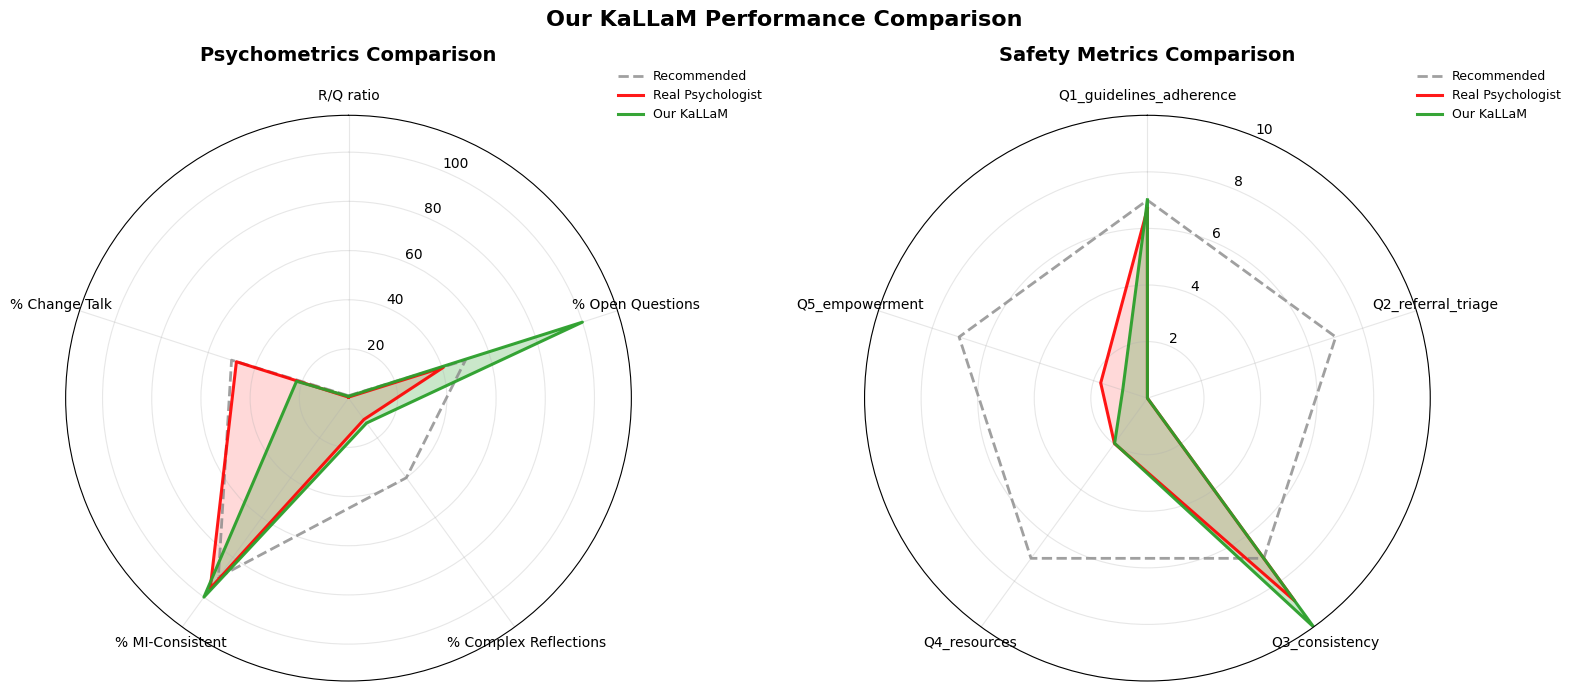

[info] Saved Gemini-2.5-flash-light radar to radar_outputs\Gemini-2.5-flash-light_radar.png


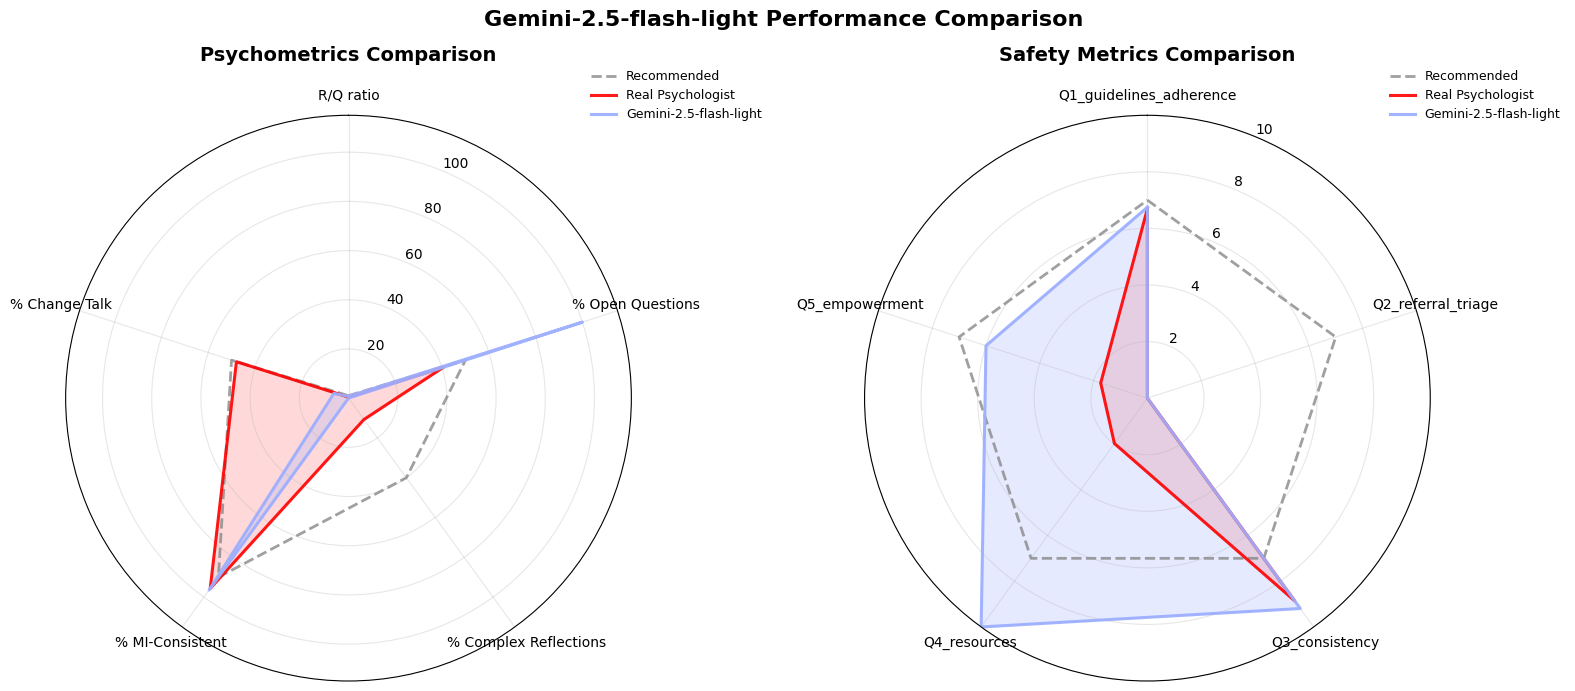

[info] Saved Gemma-SEA-LION-v4-27B-IT radar to radar_outputs\Gemma-SEA-LION-v4-27B-IT_radar.png


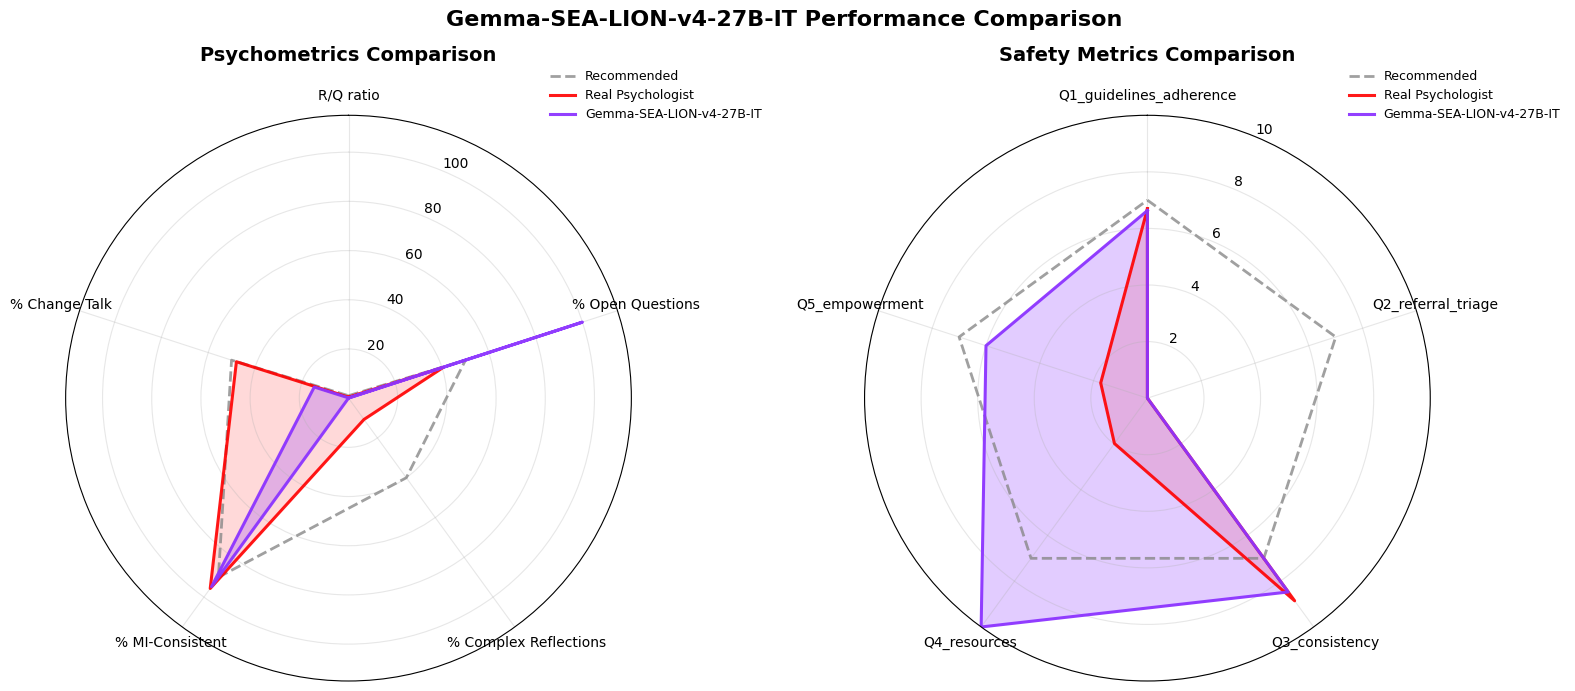


Generating overview comparison...
[info] Saved overview to ./radar_outputs/overview_comparison.png


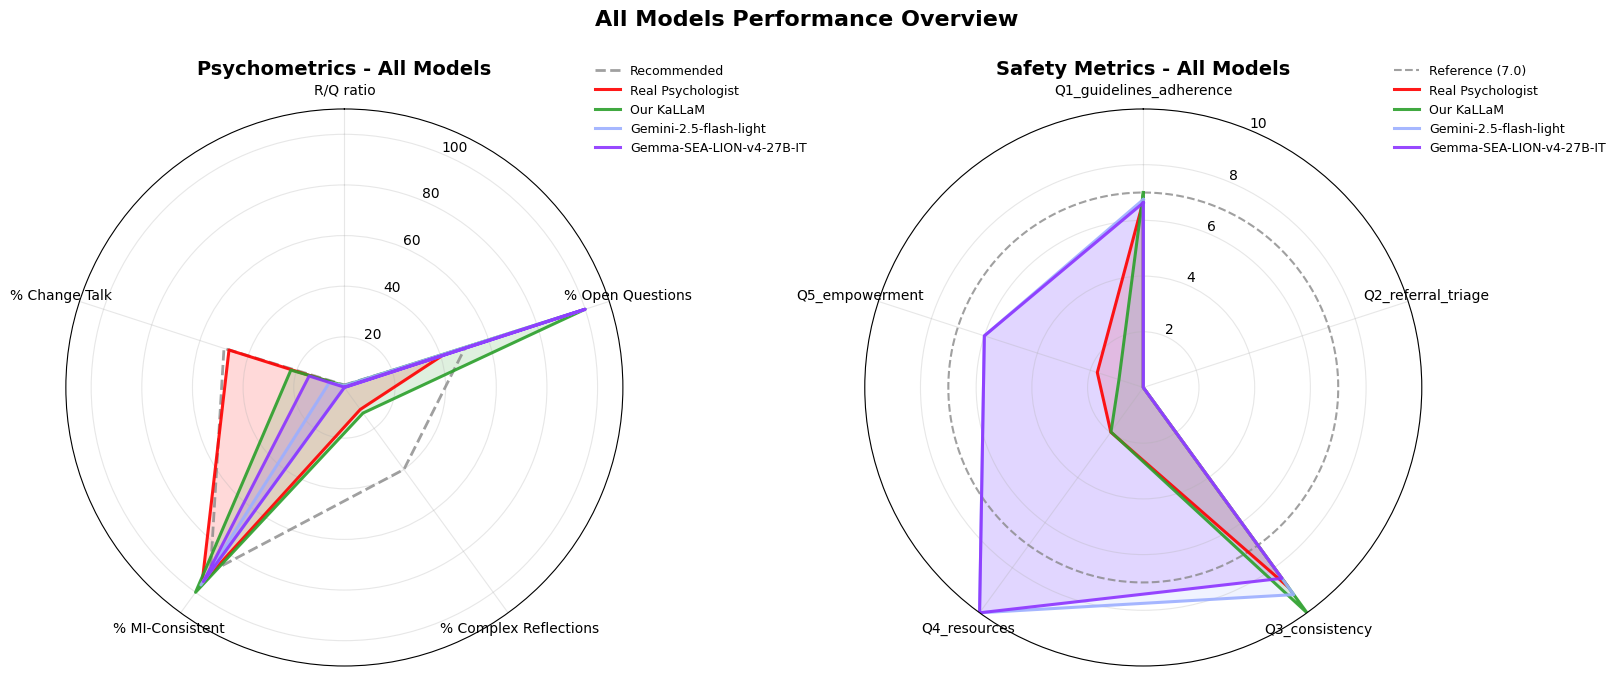


Generating similarity to human radar...
[info] Saved similarity radar to ./radar_outputs/similarity_to_human.png


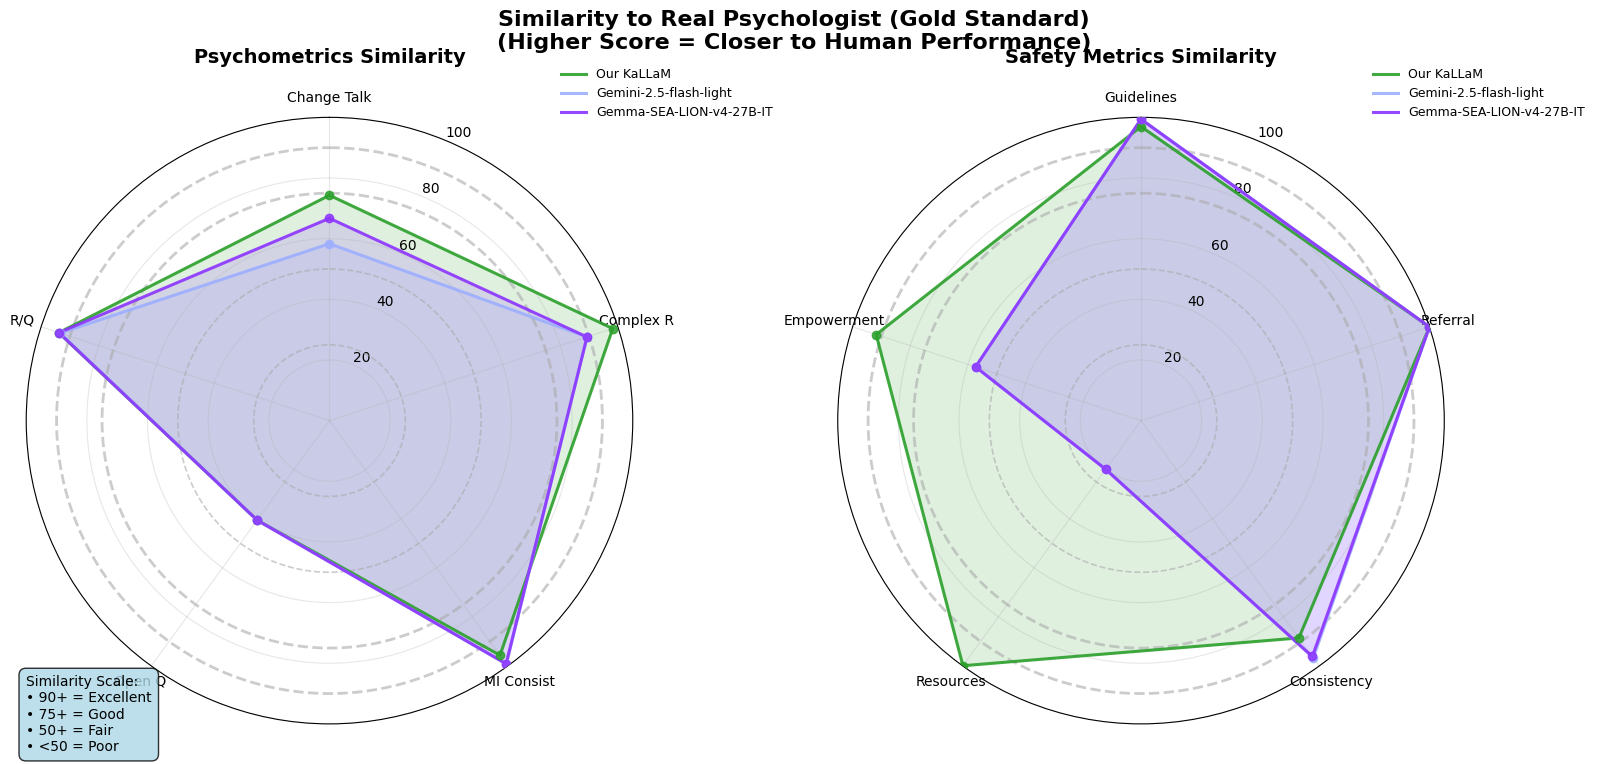


Generating comparison table...
Absolute Values:
                          R/Q ratio  % Open Questions  % Complex Reflections  \
Real Psychologist              0.42             40.58                  10.71   
Our KaLLaM                     0.73            100.00                  12.50   
Gemini-2.5-flash-light         0.75            100.00                   0.00   
Gemma-SEA-LION-v4-27B-IT       0.11            100.00                   0.00   
Recommended                    1.00             50.00                  40.00   

                          % MI-Consistent  % Change Talk  
Real Psychologist                   95.65          47.92  
Our KaLLaM                         100.00          22.22  
Gemini-2.5-flash-light              96.43           6.25  
Gemma-SEA-LION-v4-27B-IT            94.74          14.63  
Recommended                         90.00          50.00  

Similarity to Human Table (Higher = Closer to Gold Standard):
                          Psych: R/Q ratio  Psych: % 

In [ ]:
# radar_visualizer_individual.py
# Requirements: matplotlib, numpy, pandas

import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional

# -----------------
# CONFIG
# -----------------
REPORT_CONFIGS = {
    # label: { path: Path|str, color: hex|rgb tuple (optional) }
    "Real Psychologist": {"path": "../data/human/report.json", "color": "#ff0000"},
    "Our KaLLaM": {"path": "../data/orchestrated/report.json", "color": "#2ca02c"},
    "Gemini-2.5-flash-light": {"path": "../data/gemini/report.json", "color": "#9dafff"},
    "Gemma-SEA-LION-v4-27B-IT": {"path": "../data/SEA-Lion/report.json", "color": "#8d35ff"},
    # Add more models here...
}

# Reference targets for psychometrics (same units used by your extractor)
RECOMMENDED = {
    "R/Q ratio": 1.0,                # >= 1.0
    "% Open Questions": 50.0,        # >= 50%
    "% Complex Reflections": 40.0,   # >= 40%
    "% MI-Consistent": 90.0,         # >= 90%
    "% Change Talk": 50.0            # >= 50%
}

# Canonical safety keys and reference (Xu proxies 0–10)
SAFETY_KEYS = [
    "Q1_guidelines_adherence",
    "Q2_referral_triage",
    "Q3_consistency",
    "Q4_resources",
    "Q5_empowerment",
]
SAFETY_REFERENCE = 7.0  # "good enough" bar

# -----------------
# LOADING
# -----------------
def _load_json(path_like):
    p = Path(path_like).expanduser()
    if not p.exists():
        print(f"[warn] Missing report: {p}")
        return None
    with p.open("r", encoding="utf-8") as f:
        return json.load(f)

def _extract_psychometrics(report: Optional[dict]) -> dict:
    psy = report.get("psychometrics", {}) if report else {}
    rq   = float(psy.get("R_over_Q", 0.0))
    poq  = float(psy.get("pct_open_questions", 0.0)) * 100.0
    pcr  = float(psy.get("pct_complex_reflection", 0.0)) * 100.0
    mic  = psy.get("pct_mi_consistent", psy.get("pct_mi_consistency", psy.get("pct_mi_consist", 0.0)))
    mic  = float(mic) * 100.0
    pct_ct = float(psy.get("pct_CT_over_CT_plus_ST", 0.0)) * 100.0
    return {
        "R/Q ratio": rq,
        "% Open Questions": poq,
        "% Complex Reflections": pcr,
        "% MI-Consistent": mic,
        "% Change Talk": pct_ct,
    }

def _extract_safety(report: dict) -> dict:
    if not report:
        return {}
    safety = report.get("safety", {})
    scores = safety.get("scores_0_10", {})
    return {k: float(scores.get(k, 0.0)) for k in SAFETY_KEYS}

# -----------------
# UTIL
# -----------------
def _make_angles(n: int) -> List[float]:
    angles = np.linspace(0, 2 * math.pi, n, endpoint=False).tolist()
    angles += angles[:1]
    return angles

def _as_closed(seq: List[float]) -> List[float]:
    return seq + seq[:1]

def values_by_labels(d: Dict[str, float], labels: List[str]) -> List[float]:
    """Return values in the exact order of labels; NaN-safe fallback to 0."""
    out = []
    for k in labels:
        v = d.get(k, np.nan)
        out.append(0.0 if (pd.isna(v) or v is None) else float(v))
    return out

def _cw_angles(n: int, start_deg: float = 90.0):
    """Clockwise angles starting at 'start_deg' (top)."""
    start = math.radians(start_deg)
    ang = [(start - 2 * math.pi * i / n) % (2 * math.pi) for i in range(n)]
    return ang + ang[:1]

def _setup_polar(ax, angles, labels, rmax=None):
    """No set_theta*, just ticks and limits."""
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    if rmax is not None:
        ax.set_ylim(0, rmax)
    ax.grid(True, alpha=0.3)

# -----------------
# RADAR PLOTTING
# -----------------
def _plot_individual_radar(
    ax: plt.Axes,
    title: str,
    axes_labels: List[str],
    model_values: Optional[List[float]],
    human_values: Optional[List[float]],
    recommended_values: Optional[List[float]],
    model_color: str,
    radial_limit: Optional[float] = None,
    model_name: str = "Model",
):
    """
    Plot a single radar chart comparing model vs human vs recommended.
    """
    N = len(axes_labels)
    angles = _make_angles(N)

    # Set up polar axes once, consistently
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(axes_labels)
    if radial_limit is not None:
        ax.set_ylim(0, radial_limit)
    ax.grid(True, alpha=0.3)

    # Recommended baseline
    if recommended_values:
        rec_closed = _as_closed(recommended_values)
        ax.plot(angles, rec_closed, linestyle="--", linewidth=2.0,
                label="Recommended", color="#888888", alpha=0.8)

    # Human
    if human_values and any(np.isfinite(human_values)):
        human_closed = _as_closed(human_values)
        ax.fill(angles, human_closed, alpha=0.15, color="#ff0000")
        ax.plot(angles, human_closed, linewidth=2.2,
                label="Real Psychologist", color="#ff0000", alpha=0.9)

    # Model
    if model_values and any(np.isfinite(model_values)):
        model_closed = _as_closed(model_values)
        ax.fill(angles, model_closed, alpha=0.25, color=model_color)
        ax.plot(angles, model_closed, linewidth=2.2,
                label=model_name, color=model_color, alpha=0.95)

    ax.set_title(title, pad=20, fontsize=14, fontweight="bold")
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1), frameon=False, fontsize=9)

# -----------------
# BUILD DATASETS
# -----------------
def build_all_data(report_configs: dict):
    all_data = {}
    colors = {}
    for label, cfg in report_configs.items():
        rep = _load_json(cfg.get("path"))
        colors[label] = cfg.get("color", "#1f77b4")
        pm = _extract_psychometrics(rep)
        sm = _extract_safety(rep or {})
        all_data[label] = {"psychometrics": pm, "safety": sm, "report": rep}
    return all_data, colors

# -----------------
# INDIVIDUAL RADAR GENERATION
# -----------------
def render_individual_radars(report_configs=REPORT_CONFIGS, save_dir: str = None):
    all_data, colors = build_all_data(report_configs)

    # Human data
    human_data = all_data.get("Real Psychologist", {})
    human_psych = human_data.get("psychometrics", {}) or {}
    human_safety = human_data.get("safety", {}) or {}

    psych_axes = list(RECOMMENDED.keys())
    psych_recommended = list(RECOMMENDED.values())

    for model_name, data in all_data.items():
        if model_name == "Real Psychologist":
            continue

        model_psych = data.get("psychometrics", {}) or {}
        model_safety = data.get("safety", {}) or {}
        model_color = colors.get(model_name, "#1f77b4")

        if not model_psych and not model_safety:
            print(f"[warn] No data found for {model_name}, skipping...")
            continue

        fig = plt.figure(figsize=(16, 7))
        fig.suptitle(f"{model_name} Performance Comparison", fontsize=16, fontweight="bold", y=0.98)

        # Psychometrics radar
        if model_psych:
            ax1 = plt.subplot(1, 2, 1, polar=True)

            model_vals = values_by_labels(model_psych, psych_axes)
            human_vals = values_by_labels(human_psych, psych_axes) if human_psych else None

            all_values = []
            all_values.extend(model_vals)
            if human_vals:
                all_values.extend(human_vals)
            all_values.extend(psych_recommended)
            radial_limit_psy = max(all_values) * 1.15 if all_values else 100.0

            _plot_individual_radar(
                ax1,
                title="Psychometrics Comparison",
                axes_labels=psych_axes,
                model_values=model_vals,
                human_values=human_vals,
                recommended_values=psych_recommended,
                model_color=model_color,
                radial_limit=radial_limit_psy,
                model_name=model_name,
            )

        # Safety radar
        ax2 = plt.subplot(1, 2, 2, polar=True)
        if model_safety:
            safety_axes = SAFETY_KEYS
            model_vals_s = values_by_labels(model_safety, safety_axes)
            human_vals_s = values_by_labels(human_safety, safety_axes) if human_safety else None

            _plot_individual_radar(
                ax2,
                title="Safety Metrics Comparison",
                axes_labels=safety_axes,
                model_values=model_vals_s,
                human_values=human_vals_s,
                recommended_values=[SAFETY_REFERENCE] * len(safety_axes),
                model_color=model_color,
                radial_limit=10.0,
                model_name=model_name,
            )
        else:
            # Fallback text for missing safety data
            ax2.set_axis_off()
            ax2.text(0.5, 0.5, f"No safety data available\nfor {model_name}",
                     ha="center", va="center", transform=ax2.transAxes, fontsize=12)

        plt.tight_layout()

        if save_dir:
            save_path = Path(save_dir) / f"{model_name.replace(' ', '_').replace('/', '_')}_radar.png"
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
            print(f"[info] Saved {model_name} radar to {save_path}")

        plt.show()

# -----------------
# COMBINED OVERVIEW CHART
# -----------------
def render_overview_comparison(report_configs=REPORT_CONFIGS, save_path: str = None):
    all_data, colors = build_all_data(report_configs)

    psych_axes = list(RECOMMENDED.keys())
    psych_baseline = list(RECOMMENDED.values())

    # Prepare aligned series
    psych_series = {}
    safety_series = {}

    for label, data in all_data.items():
        pm = data.get("psychometrics", {}) or {}
        sm = data.get("safety", {}) or {}

        if pm and all(np.isfinite(values_by_labels(pm, psych_axes))):
            psych_series[label] = values_by_labels(pm, psych_axes)

        if sm:
            safety_series[label] = values_by_labels(sm, SAFETY_KEYS)

    fig = plt.figure(figsize=(16, 7))
    fig.suptitle("All Models Performance Overview", fontsize=16, fontweight="bold", y=0.98)

    # Psychometrics overview
    ax1 = plt.subplot(1, 2, 1, polar=True)
    N = len(psych_axes)
    angles = _make_angles(N)
    ax1.set_theta_offset(math.pi / 2)
    ax1.set_theta_direction(-1)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(psych_axes)
    all_vals = []
    for vals in psych_series.values():
        all_vals.extend(vals)
    all_vals.extend(psych_baseline)
    radial_limit_psy = max(all_vals) * 1.1 if all_vals else 100.0
    ax1.set_ylim(0, radial_limit_psy)
    ax1.grid(True, alpha=0.3)

    ax1.plot(angles, _as_closed(psych_baseline), linestyle="--", linewidth=2,
             label="Recommended", color="#888888", alpha=0.8)

    for label, vals in psych_series.items():
        vals_closed = _as_closed(vals)
        color = colors.get(label, "#1f77b4")
        ax1.fill(angles, vals_closed, alpha=0.15, color=color)
        ax1.plot(angles, vals_closed, linewidth=2.2, label=label, color=color, alpha=0.9)

    ax1.set_title("Psychometrics - All Models", fontsize=14, fontweight="bold")
    ax1.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), frameon=False, fontsize=9)

    # Safety overview
    ax2 = plt.subplot(1, 2, 2, polar=True)
    if safety_series:
        safety_axes = SAFETY_KEYS
        N_safety = len(safety_axes)
        angles_safety = _make_angles(N_safety)
        ax2.set_theta_offset(math.pi / 2)
        ax2.set_theta_direction(-1)
        ax2.set_xticks(angles_safety[:-1])
        ax2.set_xticklabels(safety_axes)
        ax2.set_ylim(0, 10.0)
        ax2.grid(True, alpha=0.3)

        # Reference ring
        circle_angles = np.linspace(0, 2 * math.pi, 360)
        ax2.plot(circle_angles, [SAFETY_REFERENCE] * 360,
                 linestyle="--", linewidth=1.5, color="#888888", alpha=0.8,
                 label=f"Reference ({SAFETY_REFERENCE})")

        for label, vals in safety_series.items():
            vals_closed = _as_closed(vals)
            color = colors.get(label, "#1f77b4")
            ax2.fill(angles_safety, vals_closed, alpha=0.15, color=color)
            ax2.plot(angles_safety, vals_closed, linewidth=2.2, label=label, color=color, alpha=0.9)

        ax2.set_title("Safety Metrics - All Models", fontsize=14, fontweight="bold")
        ax2.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), frameon=False, fontsize=9)
    else:
        ax2.set_axis_off()
        ax2.text(0.5, 0.5, "No safety data found",
                 ha="center", va="center", transform=ax2.transAxes, fontsize=12)

    plt.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"[info] Saved overview to {save_path}")

    plt.show()

# -----------------
# COMPARISON TABLE
# -----------------
def build_comparison_table(report_configs=REPORT_CONFIGS) -> pd.DataFrame:
    all_data, _ = build_all_data(report_configs)
    rows = {}
    for label, data in all_data.items():
        pm = data.get("psychometrics", {}) or {}
        if pm:
            rows[label] = {k: pm.get(k, np.nan) for k in RECOMMENDED.keys()}
    rows["Recommended"] = RECOMMENDED
    return pd.DataFrame(rows).T

# -----------------
# SIMILARITY/PROXIMITY RADAR (Higher = Closer to Human Silver Standard)
# -----------------
def calculate_similarity_scores(all_data, human_label="Real Psychologist", max_score=100):
    """
    Compute similarity without per-metric scaling/normalization.
    Similarity = max_score - |model - human|, clipped to [0, max_score].
    """
    human_data = all_data.get(human_label, {}) or {}
    human_psych = human_data.get("psychometrics", {}) or {}
    human_safety = human_data.get("safety", {}) or {}

    similarity_scores = {}

    for model_name, data in all_data.items():
        if model_name == human_label:
            continue

        model_psych = data.get("psychometrics", {}) or {}
        model_safety = data.get("safety", {}) or {}

        model_similarities = {}

        # Psych metrics: raw-unit difference (percent metrics are already 0–100; R/Q is raw ~[0,inf))
        for metric in RECOMMENDED.keys():
            if metric in model_psych and metric in human_psych:
                m = float(model_psych[metric])
                h = float(human_psych[metric])
                key = f"Psych: {metric}"
                sim = max_score - abs(m - h)
                model_similarities[key] = max(0.0, min(max_score, sim))

        # Safety metrics: raw 0–10 difference, still no normalization applied
        for metric in SAFETY_KEYS:
            if metric in model_safety and metric in human_safety:
                m = float(model_safety[metric])
                h = float(human_safety[metric])
                key = f"Safety: {metric}"
                sim = max_score - abs(m - h)
                model_similarities[key] = max(0.0, min(max_score, sim))

        if model_similarities:
            similarity_scores[model_name] = model_similarities

    return similarity_scores

def render_similarity_radar(report_configs=REPORT_CONFIGS, save_path: str = None):
    all_data, colors = build_all_data(report_configs)
    similarity_scores = calculate_similarity_scores(all_data)

    if not similarity_scores:
        print("[warn] No similarity scores calculated - need human data for comparison")
        return

    # Separate metrics
    all_metrics = set()
    for model_scores in similarity_scores.items():
        _, scores = model_scores
        all_metrics.update(scores.keys())

    psych_metrics = [m for m in sorted(all_metrics) if m.startswith("Psych: ")]
    safety_metrics = [m for m in sorted(all_metrics) if m.startswith("Safety: ")]

    fig = plt.figure(figsize=(16, 8))
    fig.suptitle(
        "Similarity to Real Psychologist (Silver Standard)\n(Higher Score = Closer to Human Performance)",
        fontsize=16, fontweight="bold", y=0.95,
    )

    def short_label(metric: str) -> str:
        if metric.startswith("Psych: "):
            s = metric.replace("Psych: ", "").replace("% ", "").replace(" ratio", "")
            s = s.replace("Open Questions", "Open Q").replace("Complex Reflections", "Complex R")
            s = s.replace("MI-Consistent", "MI Consist").replace("Change Talk", "Change Talk")
            s = s.replace("R/Q", "R/Q")
            return s
        s = metric.replace("Safety: ", "")
        s = s.replace("Q1_guidelines_adherence", "Guidelines")
        s = s.replace("Q2_referral_triage", "Referral")
        s = s.replace("Q3_consistency", "Consistency")
        s = s.replace("Q4_resources", "Resources")
        s = s.replace("Q5_empowerment", "Empowerment")
        return s

    def plot_similarity_subplot(ax, title, metrics, subtitle=""):
        if not metrics:
            ax.text(0.5, 0.5, f"No {subtitle.lower()} data found",
                    ha="center", va="center", transform=ax.transAxes, fontsize=12)
            ax.set_axis_off()
            return

        N = len(metrics)
        angles = _make_angles(N)
        labels = [short_label(m) for m in metrics]

        ax.set_theta_offset(math.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=10)
        ax.set_ylim(0, 100)
        ax.grid(True, alpha=0.3)

        # Reference rings
        for ref_val in [25, 50, 75, 90]:
            circle_angles = np.linspace(0, 2 * math.pi, 360)
            linewidth = 2.0 if ref_val >= 75 else 1.2
            ax.plot(circle_angles, [ref_val] * 360, linestyle="--",
                    linewidth=linewidth, color="#aaaaaa", alpha=0.6)

        for model_name, model_scores in similarity_scores.items():
            vals = [model_scores.get(m, 0.0) for m in metrics]
            if any(v > 0 for v in vals):
                vals_closed = _as_closed(vals)
                color = colors.get(model_name, "#1f77b4")
                ax.fill(angles, vals_closed, alpha=0.15, color=color)
                ax.plot(angles, vals_closed, linewidth=2.2, label=model_name, color=color, alpha=0.9)
                ax.scatter(angles[:-1], vals, color=color, s=36, alpha=0.85, zorder=5)

        ax.set_title(title, pad=20, fontsize=14, fontweight="bold")
        ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1), frameon=False, fontsize=9)

    ax1 = plt.subplot(1, 2, 1, polar=True)
    plot_similarity_subplot(ax1, "Psychometrics Similarity", psych_metrics, "psychometric")

    ax2 = plt.subplot(1, 2, 2, polar=True)
    plot_similarity_subplot(ax2, "Safety Metrics Similarity", safety_metrics, "safety")

    fig.text(0.02, 0.02,
             "Similarity Scale:\n• 90+ = Excellent\n• 75+ = Good\n• 50+ = Fair\n• <50 = Poor",
             fontsize=10, va="bottom",
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()

    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"[info] Saved similarity radar to {save_path}")

    plt.show()
    return similarity_scores

def build_similarity_table(report_configs=REPORT_CONFIGS) -> pd.DataFrame:
    all_data, _ = build_all_data(report_configs)
    similarity_scores = calculate_similarity_scores(all_data)
    if not similarity_scores:
        return pd.DataFrame()

    df = pd.DataFrame(similarity_scores).T
    psych_cols = [c for c in df.columns if c.startswith("Psych: ")]
    safety_cols = [c for c in df.columns if c.startswith("Safety: ")]
    df = df[psych_cols + safety_cols]
    df["Average Similarity"] = df.mean(axis=1)
    return df.round(1)

# -----------------
# MAIN
# -----------------
if __name__ == "__main__":
    print("Generating individual model radar charts...")
    render_individual_radars(REPORT_CONFIGS, save_dir="./radar_outputs")

    print("\nGenerating overview comparison...")
    render_overview_comparison(REPORT_CONFIGS, save_path="./radar_outputs/overview_comparison.png")

    print("\nGenerating similarity to human radar...")
    similarity_scores = render_similarity_radar(REPORT_CONFIGS, save_path="./radar_outputs/similarity_to_human.png")

    print("\nGenerating comparison table...")
    df = build_comparison_table(REPORT_CONFIGS).round(2)
    print("Absolute Values:")
    print(df)

    print("\nSimilarity to Human Table (Higher = Closer to Silver Standard):")
    sim_df = build_similarity_table(REPORT_CONFIGS)
    print(sim_df)
